In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from keras import layers
import time
from IPython import display
from PIL import Image
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import keras
import gdown
from zipfile import ZipFile

# we don't need test data in GAN networks :


In [4]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")



In [63]:
dataset = keras.utils.image_dataset_from_directory("celeba_gan", label_mode=None, image_size=(64, 64), batch_size=16 , shuffle=6000)

Found 202599 files belonging to 1 classes.


In [64]:
dataset = dataset.map(lambda x: ((x -127.5) / 127.5))

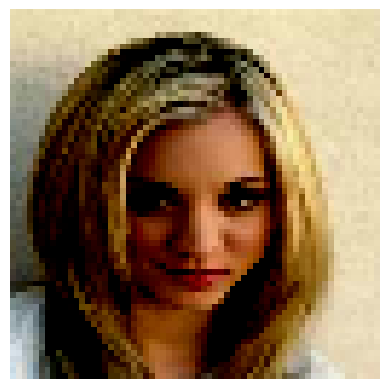

In [65]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

# Normalizing pixels :

In [66]:
dataset

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [67]:
train_dataset = dataset

# Create the models :

# discriminator : (convolution)

In [68]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64 , (5,5) , strides=(2,2) , padding="same" , input_shape=[64,64,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(filters=32 , kernel_size=(5,5) , strides=(2,2) ,padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(2)) # 2 neuron in last layer bc of classification (real / fake)

  return model


In [69]:
model = make_discriminator_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)            

# GENERATOR :

In [70]:
def make_generator_model():
  model = tf.keras.Sequential()
  # here in first layer , we have dense
  model.add(layers.Dense(8*8*128 , use_bias=False , input_shape=(100, )))
  model.add(layers.Reshape((8, 8, 128)))
  model.add(layers.BatchNormalization())

  # deconvolution
  model.add(layers.Conv2DTranspose(filters=16 , kernel_size=(4,4) , strides=(2,2) ,padding="same" , use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(filters=8 , kernel_size=(4,4) , strides=(2,2) ,padding="same" , use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(filters=4 , kernel_size=(4,4) , strides=(2,2) ,padding="same" , use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(filters=3 , kernel_size=(3,3)  ,padding="same" , use_bias=False ,activation="tanh"))

  return model

In [71]:
model = make_generator_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 8192)              819200    
                                                                 
 reshape_14 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_43 (Ba  (None, 8, 8, 128)         512       
 tchNormalization)                                               
                                                                 
 conv2d_transpose_33 (Conv2  (None, 16, 16, 16)        32768     
 DTranspose)                                                     
                                                                 
 batch_normalization_44 (Ba  (None, 16, 16, 16)        64        
 tchNormalization)                                               
                                                     

In [72]:
generator = make_generator_model()
noise = tf.random.normal((1,100))
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.1810899 ,  0.30191532, -0.6133124 ,  0.9574675 ,  3.8196547 ,
        -0.22383243,  0.3676579 ,  0.40284437,  0.5036622 , -0.7573769 ,
         0.8928495 ,  0.2589658 ,  0.89118075,  0.49093816,  0.16541827,
         1.2793928 , -1.5988381 ,  0.12222353,  0.05650001,  1.0645826 ,
        -0.08862411, -1.884144  ,  0.47546688,  0.53042203,  0.69507766,
         1.2898917 ,  0.23165673, -0.01623604,  0.5333986 , -0.05929235,
        -1.6580684 , -0.04467498, -0.7766626 , -1.3677577 ,  0.10845885,
         0.5578042 ,  0.93211424, -0.39785603, -0.47573474, -0.70852995,
        -0.25067198, -1.1382185 , -1.559007  , -0.24325237, -1.168656  ,
         1.0449489 ,  0.780522  , -1.0084587 , -1.7764872 ,  0.18002298,
        -0.5854811 , -0.88687664, -0.954559  ,  0.03809193,  1.5766407 ,
        -0.60483444, -0.26259115, -0.6060332 ,  1.1619002 ,  0.2974754 ,
        -0.09437647, -1.3830609 ,  0.33727872, -0.9640138 , -0.6190241 ,
 

# input of the GAN is noise

In [73]:
# give noise to generator , and want an output from it without any training
generated_image = generator(noise , training=False)

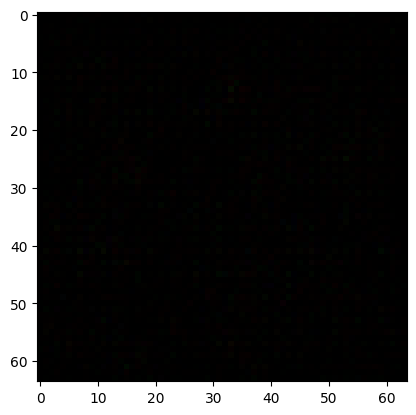

In [74]:
plt.imshow(generated_image[0 , : , : ,: ] )

# it's random Because it has not yet been trained .
and generator's weights are random .

## call discriminator function :

In [75]:
discriminator  = make_discriminator_model()

# now give this random image to discriminator :
# it will also give a random answer , bc its not been trained yet
decision = discriminator(generated_image)
decision

# if decision > 0.5  = real
# if decision < 0.5  = fake

# so   :
# discriminator says that generated image is fake image

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.00142266,  0.00128619]], dtype=float32)>

# both of the discriminator and generator have to be trained , to give true outputs

we compute loss from discriminator output , loss should be binarycrossentropy , bc its a classification problem .

categoricalcrossentropy is for multiple class classification.

although , we can also say this ::
bc of 2 class , i want 2 neurons in last layer
there for , we should use categoricalcrossentropy

لاسی که برای دیسکریمینیتور قراره حساب بشه‌
‌قراره یک کراس انتروپی باشه که روی دیتاهای ریل محاسبه شده و یک کراس انتروپی باشه که روی دیتاهای فیک محاسبه شده و قراره که اینا باهم جمع بشن


In [76]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output , fake_output):
  real_loss = cross_entropy( tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output) , fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#   total_loss is discriminator loss


def generator_loss(fake_output):
  return cross_entropy( tf.ones_like(fake_output), fake_output)

In [77]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(0.0001)

discriminator_optimizer = tf.keras.optimizers.legacy.Adam(0.0001)

# way to save train process in case of losing GPU while training ::
create checkpoint

In [78]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir , "chpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer ,
                                 discriminator_optimizer= discriminator_optimizer ,
                                 generator = generator ,
                                 discriminator = discriminator)

here we dont have accuracy , but we wnt to see real images in output

In [85]:
EPOCHS = 20
noise_dimension = 100
num_example_to_generate = 16

seed = tf.random.normal([num_example_to_generate  ,  noise_dimension])

In [86]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :].numpy() * 127.5  + 127.5 ).astype("uint32"))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [87]:
@tf.function
def train_step(images):
    noise = tf.random.normal([16, noise_dimension])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # some noises enter into generator network
        # and some images will be generated
        generated_images = generator(noise, training=True)

        # with <<<< training=True >>>> , weights will be updated and gradients will be computed

        # some real images enter into descriminator , and it learns them
        real_output = discriminator(images, training=True)
        # then , generated images , enter into descriminator , and it learns them
        fake_output = discriminator(generated_images, training=True)

        # fine tune training
        #it will only learn fake outputs
        gen_loss = generator_loss(fake_output)

        # it should learn both real and fake
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in (dataset):
      train_step(image_batch)

    # for display output
    # produce images for GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator , epoch + 1 , seed)
    # save model every 15 epochs
    if (epoch + 1) % 15 ==0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator , epochs , seed)



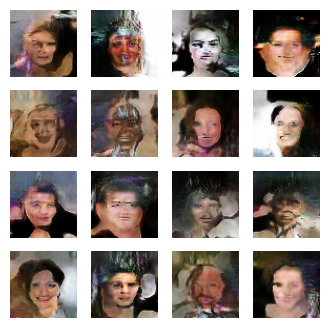

In [88]:
train(train_dataset, EPOCHS)


# create a GIF file :

In [89]:
anim_file ='celebA.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-89-e097cfea6798>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-89-e097cfea6798>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
